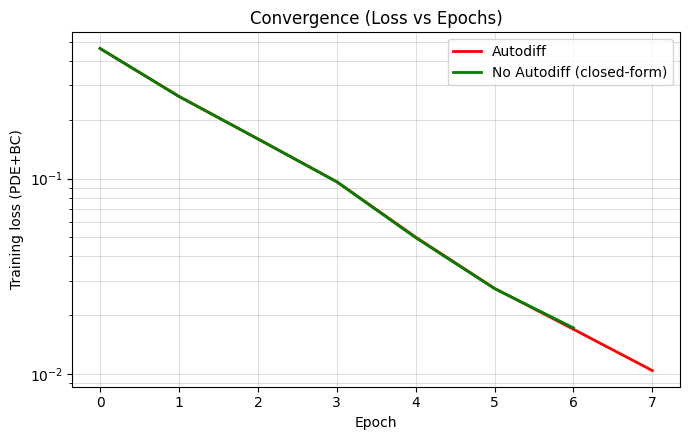

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(x, k=11):
    if k <= 1 or k > len(x): return x
    w = np.ones(k)/k
    return np.convolve(x, w, mode="valid")

# Load logs (each file produced by its run)
L_auto = np.load("kg_loss_autodiff.npy")
L_noad = np.load("kg_loss_without_autodiff.npy")

# Optional smoothing (set k=1 to disable)
k = 9
L_auto_s = moving_average(L_auto, k)
L_noad_s = moving_average(L_noad, k)

# Epoch axes (handle different lengths after smoothing)
ea = np.arange(len(L_auto_s))
en = np.arange(len(L_noad_s))

plt.figure(figsize=(7,4.5))
plt.semilogy(ea, L_auto_s, label="Autodiff", color="red", linewidth=2)
plt.semilogy(en, L_noad_s, label="No Autodiff (closed-form)", color="green", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Training loss (PDE+BC)")
plt.title("Convergence (Loss vs Epochs)")
plt.grid(True, which="both", linewidth=0.5, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("kg_convergence_loss_both.svg", format="svg", facecolor='none',
            transparent=True, bbox_inches="tight")
plt.show()

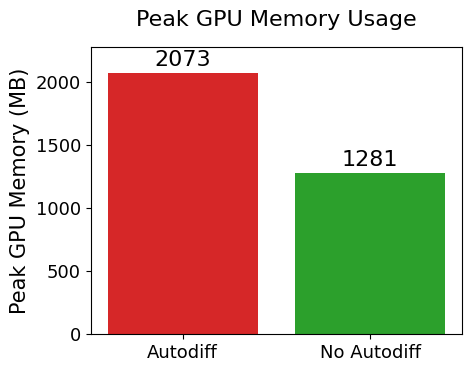

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load saved values
mem_auto = np.load("kg_peak_mem_autodiff.npy")
mem_noad = np.load("kg_peak_mem_without_autodiff.npy")


plt.rcParams.update({
    "font.size": 16,           # general text
    "axes.titlesize": 16,      
    "axes.labelsize": 15,      
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13
})



plt.figure(figsize=(5,4))
plt.bar(["Autodiff", "No Autodiff"], [mem_auto, mem_noad],
        color=["tab:red","tab:green"])
plt.ylabel("Peak GPU Memory (MB)")
plt.title("Peak GPU Memory Usage", pad = 15)
for i, v in enumerate([mem_auto, mem_noad]):
    plt.text(i, v+20, f"{v:.0f}", ha="center", va="bottom")  # annotate values

plt.ylim(0, max(mem_auto, mem_noad) * 1.10)

plt.tight_layout()
plt.savefig("kg_peak_memory_comparison.svg", format="svg", facecolor='none',
            transparent=True, bbox_inches="tight")
plt.show()

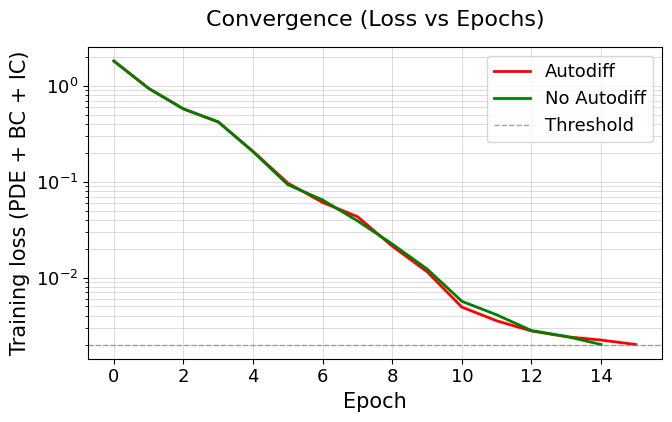

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- set your loss threshold (must match training) ---
THRESH = 2e-3

def first_crossing_idx(arr, thr):
    """Index of first epoch where loss <= thr; else last index."""
    a = np.asarray(arr, dtype=float)
    idx = np.where(a <= thr)[0]
    return int(idx[0]) if len(idx) else len(a) - 1

def trim_to_threshold(loss, thr):
    """Trim at first crossing and set final value exactly to thr."""
    a = np.asarray(loss, dtype=float)
    k = first_crossing_idx(a, thr)
    out = a[:k+1].copy()
    out[-1] = thr
    return out, (a.min() <= thr)

def moving_average(x, k=1):
    x = np.asarray(x, dtype=float)
    if k <= 1 or k > len(x): 
        return x
    w = np.ones(k) / k
    return np.convolve(x, w, mode="valid")

# ---- Load your raw histories (from each training script) ----
L_auto_raw = np.load("kg_loss_autodiff.npy")
L_noad_raw = np.load("kg_loss_without_autodiff.npy")

# ---- Trim at threshold; warn if never reached ----
L_auto_trim, hit_auto = trim_to_threshold(L_auto_raw, THRESH)
L_noad_trim, hit_noad = trim_to_threshold(L_noad_raw, THRESH)

if not hit_auto:
    print("[WARN] Autodiff run did NOT reach threshold; using last point.")
if not hit_noad:
    print("[WARN] No-Autodiff run did NOT reach threshold; using last point.")

# ---- Optional smoothing AFTER trimming (so both end at thr) ----
k = 1  # set to 1 to disable smoothing
L_auto = moving_average(L_auto_trim, k)
L_noad = moving_average(L_noad_trim, k)

# Epoch axes (post-smoothing)
ea = np.arange(len(L_auto))
en = np.arange(len(L_noad))

# Epoch counts to threshold (based on trimmed, pre-smoothed arrays)
e_auto = len(L_auto_trim) - 1
e_noad = len(L_noad_trim) - 1



plt.rcParams.update({
    "font.size": 16,           # general text
    "axes.titlesize": 16,      
    "axes.labelsize": 15,      
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13
})



plt.figure(figsize=(7, 4.5))
plt.semilogy(ea, L_auto, label=f"Autodiff", color="red", linewidth=2)
plt.semilogy(en, L_noad, label=f"No Autodiff", color="green", linewidth=2)

# Threshold guide
plt.axhline(THRESH, linestyle="--", linewidth=1, color="gray", alpha=0.7, label="Threshold")

plt.xlabel("Epoch")
plt.ylabel("Training loss (PDE + BC + IC)")
plt.title("Convergence (Loss vs Epochs)", pad = 15)
plt.grid(True, which="both", linewidth=0.5, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("kg_convergence_loss_both_threshold.svg", format="svg", transparent=True, bbox_inches="tight")
plt.show()
